## Import Library

In [2]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

## Keypoint using Mediapipe Holistic

In [3]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [4]:
# Color conversion 
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR to RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB to BGR
    return image, results

In [5]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [6]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    
    cap.release()
    cv2.destroyAllWindows()

print(results)

<class 'mediapipe.python.solution_base.SolutionOutputs'>


In [7]:
draw_styled_landmarks(image, results)

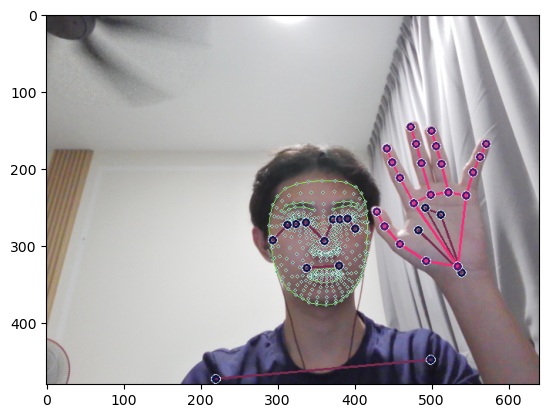

In [8]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

## Extract Keypoint Values

In [9]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

## Setup Folders for Data Collection

In [14]:
# Desired path for data
desired_path = "C:\\Users\\erwin\\Desktop\\ASL"

# Creating a subfolder for MP_Data within the desired path
DATA_PATH = os.path.join(desired_path, 'MP_Data') 

# Actions that we try to detect
actions = np.array(['hello', 'thanks', 'iloveyou'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

# Folder start
start_folder = 1

In [20]:
for action in actions: 
    action_path = os.path.join(DATA_PATH, action)
    
    # Check if the action directory exists, create if not
    if not os.path.exists(action_path):
        os.makedirs(action_path)
        dirmax = 0
    else:
        # List directories and find the max
        try:
            dirmax = np.max(np.array(os.listdir(action_path)).astype(int))
        except ValueError:  # This occurs if there are no directories
            dirmax = 0

    for sequence in range(1, no_sequences + 1):
        try: 
            os.makedirs(os.path.join(action_path, str(dirmax + sequence)))
        except:
            pass
            

## Data Collection

In [21]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(start_folder, start_folder+no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(1000)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

In [19]:
cap.release()
cv2.destroyAllWindows()

## Data Preparation and Create Labels and Features

In [148]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [149]:
label_map = {label:num for num, label in enumerate(actions)}

In [150]:
label_map

{'hello': 0, 'thanks': 1, 'iloveyou': 2}

In [151]:
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [153]:
np.array(sequences).shape

(90, 30, 1662)

In [154]:
np.array(labels).shape

(90,)

In [155]:
X = np.array(sequences)

In [156]:
X.shape

(90, 30, 1662)

In [157]:
y = to_categorical(labels).astype(int)

In [159]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Build and Train LSTM Neutral Network 

In [173]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [174]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [175]:
LSTM_model = Sequential()
LSTM_model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
LSTM_model.add(LSTM(128, return_sequences=True, activation='relu'))
LSTM_model.add(LSTM(64, return_sequences=False, activation='relu'))
LSTM_model.add(Dense(64, activation='relu'))
LSTM_model.add(Dense(32, activation='relu'))
LSTM_model.add(Dense(actions.shape[0], activation='softmax'))

c:\Users\erwin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [176]:
LSTM_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [177]:
LSTM_model.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback])

Epoch 1/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - categorical_accuracy: 0.3407 - loss: 2.8445
Epoch 2/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.3681 - loss: 12.3673
Epoch 3/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - categorical_accuracy: 0.3672 - loss: 4.4494
Epoch 4/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.4054 - loss: 7.4345
Epoch 5/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.3346 - loss: 9.2040
Epoch 6/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.2765 - loss: 11.1481
Epoch 7/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - categorical_accuracy: 0.1372 - loss: 8.3711
Epoch 8/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - categorical_accuracy: 0.2700 - loss: 5.4423
Epoch 9/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.4214 - loss: 6.7995
Epoch 10/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.3355 - loss: 17.6847
Epoch 11/2000
3/3 ━━━━━━━━

In [178]:
LSTM_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 30, 64)         │       442,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 30, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,790,027 (6.83 MB)

 Trainable params: 596,675 (2.28 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,193,352 (4.55 MB)

## Save Model

In [179]:
LSTM_model.save('action2.h5')

## Evaluation using Confusin Matrix and Accuracy - LSTM

In [180]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, classification_report, confusion_matrix

In [181]:
yhat = LSTM_model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


In [182]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [183]:
confusion_matrix(ytrue, yhat)

array([[4, 0, 0],
       [6, 0, 0],
       [8, 0, 0]], dtype=int64)

In [184]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[ 0, 14],
        [ 0,  4]],

       [[12,  0],
        [ 6,  0]],

       [[10,  0],
        [ 8,  0]]], dtype=int64)

In [185]:
print(accuracy_score(ytrue, yhat))

0.2222222222222222


In [186]:
print(classification_report(ytrue, yhat, zero_division=0))

              precision    recall  f1-score   support

           0       0.22      1.00      0.36         4
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         8

    accuracy                           0.22        18
   macro avg       0.07      0.33      0.12        18
weighted avg       0.05      0.22      0.08        18



## Test in Real Time - LSTM

In [69]:
from scipy import stats

In [70]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [187]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = LSTM_model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
        
    cap.release()
    cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
hello
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
hello
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
hello
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
hello
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
hello
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
hello
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
hello
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
hello
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
hello
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
hello
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
hello
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
hello
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
hello
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
hello
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
hello
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
hello
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
hello
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
hello
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
hello
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
hello
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
hello
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
hello
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/

## Build and Train CNN

In [160]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.callbacks import TensorBoard

In [161]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [189]:
CNN_model = Sequential()
CNN_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(30,1662)))
CNN_model.add(MaxPooling1D(pool_size=2))
CNN_model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
CNN_model.add(MaxPooling1D(pool_size=2))
CNN_model.add(Flatten())
CNN_model.add(Dense(64, activation='relu'))
CNN_model.add(Dense(32, activation='relu'))
CNN_model.add(Dense(actions.shape[0], activation='softmax'))

c:\Users\erwin\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [190]:
CNN_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [191]:
CNN_model.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback])

Epoch 1/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - categorical_accuracy: 0.2856 - loss: 1.1369
Epoch 2/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.4262 - loss: 1.1118 
Epoch 3/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - categorical_accuracy: 0.6771 - loss: 1.1211 
Epoch 4/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - categorical_accuracy: 0.3481 - loss: 1.2103
Epoch 5/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - categorical_accuracy: 0.4870 - loss: 0.9970 
Epoch 6/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - categorical_accuracy: 0.6181 - loss: 0.9317 
Epoch 7/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - categorical_accuracy: 0.5373 - loss: 0.8254 
Epoch 8/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - categorical_accuracy: 0.8147 - loss: 0.6933
Epoch 9/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.5707 - loss: 0.6467
Epoch 10/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - categorical_accuracy: 0.7639 - loss: 0.5309  
Epoch 11/2000
3/3 ━━━━━━━━━━━

In [192]:
CNN_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 28, 64)         │       319,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 14, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 12, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 6, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │        49,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,185,803 (4.52 MB)

 Trainable params: 395,267 (1.51 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 790,536 (3.02 MB)

## Save Model - CNN

In [193]:
CNN_model.save('action3.h5')

## Evaluation using Confusion Matrix and Accuracy - CNN

In [194]:
yhat = CNN_model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


In [195]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [196]:
confusion_matrix(ytrue, yhat)

array([[4, 0, 0],
       [0, 6, 0],
       [0, 0, 8]], dtype=int64)

In [197]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[14,  0],
        [ 0,  4]],

       [[12,  0],
        [ 0,  6]],

       [[10,  0],
        [ 0,  8]]], dtype=int64)

In [198]:
print(accuracy_score(ytrue, yhat))

1.0


In [199]:
print(classification_report(ytrue, yhat, zero_division=0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         8

    accuracy                           1.00        18
   macro avg       1.00      1.00      1.00        18
weighted avg       1.00      1.00      1.00        18



## Test in real time - CNN

In [200]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = CNN_model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
        
    cap.release()
    cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
iloveyou
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
iloveyou
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
iloveyou
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
iloveyou
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
iloveyou
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
iloveyou
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
iloveyou
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
iloveyou
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
iloveyou
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
iloveyou
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
iloveyou
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
iloveyou
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
iloveyou
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
iloveyou
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
iloveyou
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
iloveyou
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
iloveyou
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
iloveyou
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
hello
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
hello
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
hello
1/1 ━━━━━━━━━━━━━━━━━━━